In [254]:
# This version of the SVD fits using states expressed as excitations relative to a nuclear ground state
# RMS error for this fit looks to be a match with e35 produced by BAB
import random
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv
from scipy import stats
from IPython.display import Image

# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()
dataIn = pd.read_fwf('exp.dai', header=None).to_numpy()
nuclei = dataIn[:,6]
inputInteraction = pd.read_csv('r35c.int', header=None, delim_whitespace=True).to_numpy()

# extract the SPEs and TBME's for the background (n50em) interaction
abinitioHam = energyDF[0,6:75]                                         # ab initio Hamiltonian - First 5 terms are not Hamiltonian parameters and can be dropped
startHam = np.append(inputInteraction[0,1:5],inputInteraction[69:,6])  # starting interaction
babHam = energyDF[1,6:75]                                              # fitted interaction from BAB

# extract experimental energies and experimental errors from dataframe
exp = dataIn[:,4]
fitExp = energyDF[2:,1]
error = energyDF[2:,3]

# extract a matrix of the beta coefficients in each energy contribution for the Hamiltonian in terms of excited states
betas = np.empty([len(exp),len(startHam)])
for i in range(len(exp)):
    for j in range(len(startHam)):
        if exp[i] <= 0:
            betas[i,j] = energyDF[i+2,j+6]
            gsContributions = betas[i,:]
        else:
            betas[i,j] = energyDF[i+2,j+6] - gsContributions[j]

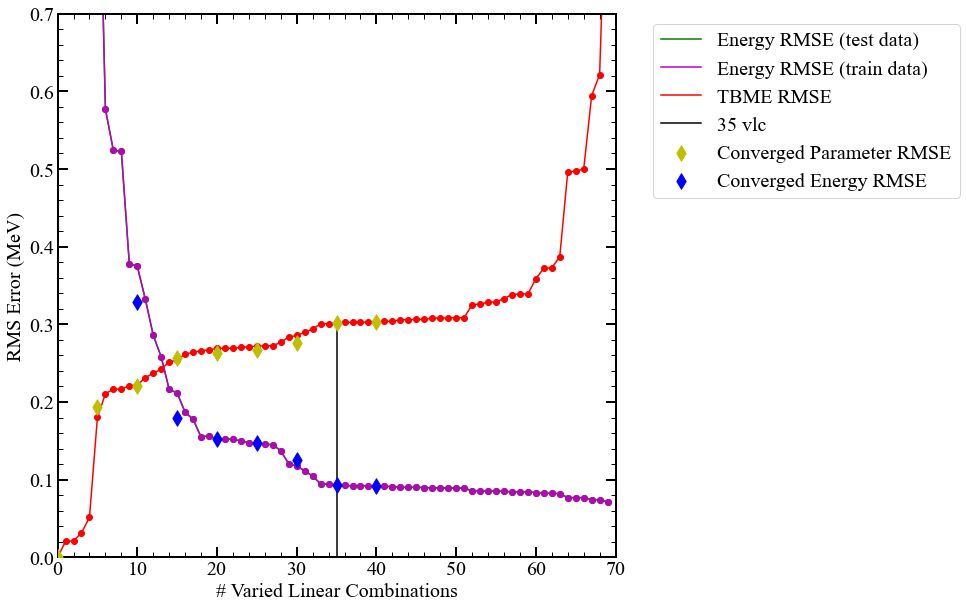

In [353]:
# This segment iterates (numBatches times) over randomized batches of the available data (including all ground states)
# All excited states from 79Cu to 99In are available for building training batches
# The full dataset is used for testing

numBatches = 1                                # Number of batches of randomly sampled data
numVLC = 35                                   # Number of VLC to choose for the output Hamiltonian
eRMSRangeAll = np.empty([numBatches,len(startHam)+1])
eRMSRangeTest = np.empty([numBatches,len(startHam)+1])
eRMSRangeTrain = np.empty([numBatches,len(startHam)+1])
pRMSRange = np.empty([numBatches, len(startHam)+1])
dataPercent = 1.0             # percent of the dataset to include in the testing sets

# Temporary variables for diagnosing fit
eTheory = []
babTheory = energyDF[2:,4]
totalData = len(exp)
groundStates = 0

for b in range(numBatches):
    # Select a random batch of data to fit the parameters to (making sure that ground states are always included in the batch)
    batchChoice = np.zeros(len(exp))
    random.seed()
    for i in range(len(exp)):
        if exp[i] <= 0.0:
            batchChoice[i] = 1
            groundStates += 1
        else:
            k = random.random()
            if k >= 1-dataPercent:
                batchChoice[i] = 1

    batchExp = np.empty(int(np.sum(batchChoice)))
    batchError = np.empty(len(batchExp))
    batchBetas = np.empty([len(batchExp), len(startHam)])
    batchIndex = 0
    for i in range(len(exp)):
        if batchChoice[i] == 1:
            batchExp[batchIndex] = fitExp[i]
            batchError[batchIndex] = error[i]
            batchBetas[batchIndex] = betas[i]
            batchIndex += 1
                    
    # Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
    e = np.empty(len(startHam))
    G = np.empty((len(startHam),len(startHam)))
    for i in range(len(startHam)):           # Contructing data vector (e)
        eTot = 0
        for k in range(len(batchExp)):
            eTot += (batchExp[k]*batchBetas[k,i])/(batchError[k]**2)
        e[i] = eTot
    for i in range(len(startHam)):           # Constructing design matrix (G)
        for j in range(len(startHam)):
            gTot = 0
            for k in range(len(batchExp)):
                gTot += (batchBetas[k,i]*batchBetas[k,j])/(batchError[k]**2)
            G[i,j] = gTot

    # Here we perform an SVD of our design matrix and invert the singular values (in S)
    # to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
    U, Svec, Ut = np.linalg.svd(G)
    # Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
    # e and p into new vectors c and y, respectively
    c = np.dot(Ut,e)
    y = np.dot(Ut,abinitioHam)

    # This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
    # at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
    pRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
    fitEnergies = np.empty(len(exp))              # Array for storing fitted energies resulting from the chosen #VLC fit
    
    for i in range(len(startHam)+1):
        goodData = 0           # TEMPORARY VARIABLE
        yfit = np.empty(len(startHam))
        fitParameters = np.empty(len(startHam))               # Array for storing fitted parameters in this iteration
        eResidualAll = np.empty(0)                             # Array for storing residuals for RMS calculation
        eResidualTest = np.empty(0)
        eResidualTrain = np.empty(0)
        for j in range(len(startHam)):
            if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
                yfit[j] = c[j]/Svec[j]
            elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
                yfit[j] = y[j]
        fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
        for j in range(len(exp)):
            eFitTot = 0
            for k in range(len(startHam)):
                eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            if i == numVLC:                                           # Save energies predicted by Hamiltonian
                eTheory.append(eFitTot)
                if exp[j] <= 0.0:
                    eTheory[j] -= 642.564
            if error[j] <= 1.0:
                goodData += 1
                eResidualAll = np.append(eResidualAll, fitExp[j]-eFitTot)
                if batchChoice[j] == 0:
                    eResidualTest = np.append(eResidualTest, fitExp[j]-eFitTot)
                elif batchChoice[j] ==1:
                    eResidualTrain = np.append(eResidualTrain, fitExp[j]-eFitTot)
        pResidual = abinitioHam[4:] - fitParameters[4:]
        pRMSRange[b,i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
        eRMSRangeAll[b,i] = scipy.linalg.norm(eResidualAll)/math.sqrt(len(eResidualAll))
        eRMSRangeTrain[b,i] = scipy.linalg.norm(eResidualTrain)/math.sqrt(len(eResidualTrain))
        if dataPercent < 1.0:
            eRMSRangeTest[b,i] = scipy.linalg.norm(eResidualTest)/math.sqrt(len(eResidualTest))
        if i == numVLC:
            outputHam = fitParameters
            tbmeRMSE = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))

# For a given number of singular values, calculate the averave RMSE across batches
eRMSaverageAll = np.empty(len(pRMS))
eRMSaverageTest = np.empty(len(pRMS))
eRMSaverageTrain = np.empty(len(pRMS))
pRMSaverage = np.empty(len(pRMS))
for i in range(len(pRMS)):
    eRMSaverageAll[i] = np.sum(eRMSRangeAll[:,i])/numBatches
    eRMSaverageTest[i] = np.sum(eRMSRangeTest[:,i])/numBatches
    eRMSaverageTrain[i] = np.sum(eRMSRangeTrain[:,i])/numBatches
    pRMSaverage[i] = np.sum(pRMSRange[:,i])/numBatches

#print('35 vlc eRMS (average) =', eRMSaverageAll[34], ' pRMS (average) = ', pRMSaverage[34])
#print('full SVD eRMS =', eRMSaverageAll[69], ' pRMS =', pRMSaverage[69])
#print('BAB parameter RMS = ', scipy.linalg.norm(startHam-fittedHam)/math.sqrt(len(startHam)))

x = [i for i in range(len(pRMS))] 
#f = plt.figure()
f, ax = plt.subplots()
f.set_figwidth(10)
f.set_figheight(10)
for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_linewidth(2)
if numBatches > 10:
    alphaValue = 10/numBatches
else:
    alphaValue = 1
for i in range(numBatches):
    #plt.scatter(x, eRMSRangeAll[i], color='b', alpha=alphaValue)
    plt.scatter(x, eRMSRangeTest[i], color='g', alpha=alphaValue)
    plt.scatter(x, eRMSRangeTrain[i], color='m', alpha=alphaValue)
    plt.scatter(x, pRMSRange[i], color='r', alpha=alphaValue)
#plt.plot(x, eRMSaverageAll, label='Energy RMS (all data)', color='b')
plt.plot(x, eRMSaverageTest, label='Energy RMSE (test data)', color='g')
plt.plot(x, eRMSaverageTrain, label='Energy RMSE (train data)', color='m')
plt.plot(x, pRMSaverage, label='TBME RMSE', color='r')
convergedX = [0, 5,10,15,20,25,30,35,40]
convergedERMSE = [2.5, 0.779, 0.329, 0.179, 0.152, 0.147, 0.125, 0.093, 0.092]
convergedPRMSE = [0.0, 0.194, 0.221, 0.257, 0.263, 0.267, 0.276, 0.302, 0.303]
plt.scatter(convergedX, convergedPRMSE, label='Converged Parameter RMSE', c='y', marker="d", s=120, zorder=4)
plt.scatter(convergedX, convergedERMSE, label='Converged Energy RMSE', c='b', marker="d",s=120, zorder=5)
plt.axvline(x = numVLC, ymin = 0, ymax = tbmeRMSE/0.7, color = 'k', label = '%i vlc' %numVLC)
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
#plt.title('r35 SVD Fit For %i Batch(es) of Data' %numBatches, fontsize=25)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="major", direction="in", right=True, top=True, length=10, width=2, labelsize=20)
plt.tick_params(which="minor", direction="in", right=True, top=True, length=5, width=1, labelsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20).set_alpha(1)
plt.show()

The red curve is the RMSE between our starting hamiltonian parameter values and our fitted values at each number of varied linear combinations of parameters (VLC's) - in other words for each number of singular values of the inverted design matrix chosen to weight the starting linear combinations of parameters.

The magenta curve is the RMSE due only to residuals between the data used to fit (train) the Hamiltonian parameters before and after the fit.
The green curve is the RMSE due only to the residuals between the data outside of the training sets (test data) before and after the fit. 
The blue curve is the RMSE due to the residual between all data (test and training) before and after the fit.

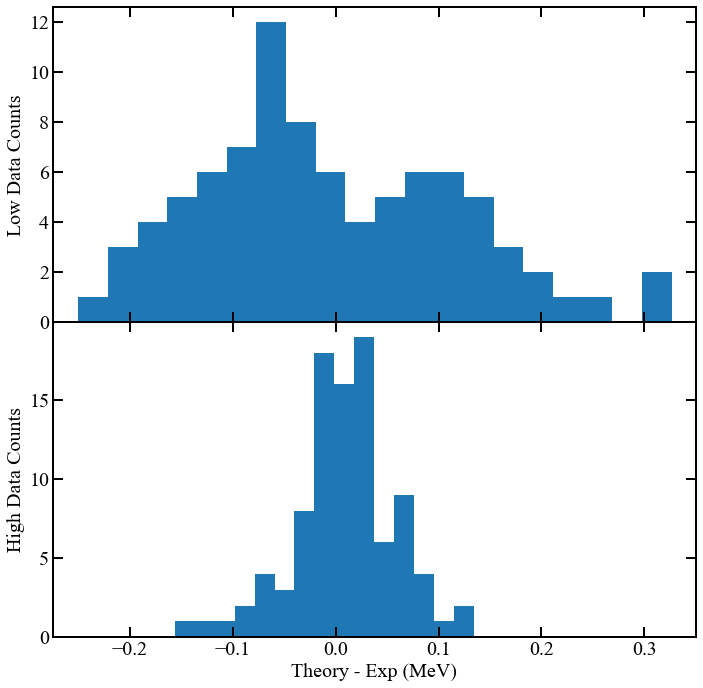

In [346]:
# Be sure to set numBatches = 1 and dataPercent = 1.0 before running this cell
lowResiduals = []
highResiduals = []
for i in range(103):
    if error[i] < 1.0:
        lowResiduals.append(eTheory[i]-exp[i])
for i in range(103,len(exp)):
    if error[i] < 1.0:
        highResiduals.append(eTheory[i]-exp[i])

f, ax = plt.subplots(nrows=2, ncols=1)
for location in ['left', 'right', 'top', 'bottom']:
    ax[0].spines[location].set_linewidth(2)
    ax[1].spines[location].set_linewidth(2)
ax[0].hist(lowResiduals, bins=20)
ax[1].hist(highResiduals, bins=15)
f.set_figwidth(10)
f.set_figheight(10)
ax[1].set_xlabel('Theory - Exp (MeV)', fontsize=20)
ax[0].set_ylabel('Low Data Counts', fontsize=20)
ax[1].set_ylabel('High Data Counts', fontsize=20)
ax[0].set_xlim(left=-0.275, right=0.35)
ax[1].set_xlim(left=-0.275, right=0.35)

f.tight_layout()
f.subplots_adjust(hspace=0.0, top=0.95)
ax[0].tick_params(which="major", direction="in", right=True, top=True, length=10, width=2, labelsize=20)
ax[1].tick_params(which="major", direction="in", right=True, top=True, length=10, width=2, labelsize=20)
plt.show()

In [257]:
outputs1 = np.array([abinitioHam, startHam, outputHam, babHam, outputHam-babHam])
tbmeDifference = outputHam[4:]-abinitioHam[4:]
with open("Hamiltonians.dat","w") as f:
    f.write("Parameters of VLC=%i Fit: \n" % numVLC)
    f.write("ab-initio      start          fit          BAB        fit-BAB\n")
    np.savetxt(f, outputs1.T, delimiter='     ', fmt='%8.4f')
    f.write("Fit RMSE of VLC=%i Fit: %4.4f \n" %(numVLC, scipy.linalg.norm(tbmeDifference)/math.sqrt(len(tbmeDifference))))
    f.write("BAB RMSE of VLC=%i Fit: %4.4f" %(numVLC, scipy.linalg.norm(babHam[4:]-abinitioHam[4:])/math.sqrt(len(babHam[4:]))))

In [296]:
diffScale = []
rmsLow = []
rmsHigh = []
rmsTot = []
mseLow = 0.0
lowCount = 0
mseHigh = 0.0
highCount = 0
allErrors = eTheory - exp
for i in range(len(exp)):
    thisSquaredError = allErrors[i]**2
    if i < 103:
        if error[i] < 1.0:
            lowCount += 1
            mseLow += thisSquaredError
    if i >= 103:
        if error[i] < 1.0:
            highCount += 1
            mseHigh += thisSquaredError
    if lowCount == 0:
        rmsLow.append(0.0)
    if lowCount > 0:
        rmsLow.append(math.sqrt(mseLow/lowCount))
    if highCount == 0:
        rmsHigh.append(math.sqrt(0.0))
    if highCount > 0:
        rmsHigh.append(math.sqrt(mseHigh/highCount))
    if (lowCount + highCount) == 0:
        currentRMS = math.sqrt(0.0)
    if (lowCount + highCount) > 0:
        currentRMS = math.sqrt((mseLow + mseHigh)/(lowCount + highCount))
    rmsTot.append(currentRMS)
rmsHighNP = np.array(rmsHigh)
rmsLowNP = np.array(rmsLow)
rmsTotNP = np.array(rmsTot)
    
for i in range(len(eTheory)):
    numSymbols = int((eTheory[i]-exp[i])/0.1)
    if numSymbols < 0.0:
        symbol = '-'
    if numSymbols > 0.0:
        symbol = '+'
    if error[i] > 1.0:
        symbol = 'o'
    thisDiff = ""
    for j in range(abs(numSymbols)):
        thisDiff += symbol
    diffScale.append(thisDiff)

outputs2 = np.array([nuclei, error, exp, eTheory, eTheory-exp, diffScale, rmsTot, rmsLow, rmsHigh])
with open("expfit.dat","w") as f:
    f.write("nuc     error      exp      theory      difference\n")
    #np.savetxt(f, outputs1.T, delimiter=' ', fmt='%s')
    np.savetxt(f, outputs2.T, delimiter='     ', fmt='%2s %10.4f %10.4f %10.4f %10.4f %-12s %10.4f %10.4f %10.4f')
    f.write("Total number of data = " + str(totalData) + "\n")
    f.write("Total number of good data = " + str(goodData) + "\n")
    f.write("Total number of ground states = " + str(groundStates))

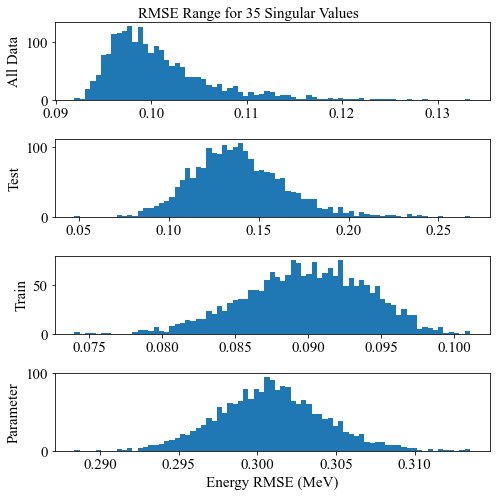

In [350]:
nSVD = 35
fs = 15
nBins = 75
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7,7))

axs[0].hist(eRMSRangeAll[:,nSVD], bins=nBins)
axs[1].hist(eRMSRangeTest[:,nSVD], bins=nBins)
axs[2].hist(eRMSRangeTrain[:,nSVD], bins=nBins)
axs[3].hist(pRMSRange[:,nSVD], bins=nBins)
axs[3].set_xlabel('Energy RMSE (MeV)', fontsize=fs)
axs[0].set_ylabel('All Data', fontsize=fs)
axs[1].set_ylabel('Test', fontsize=fs)
axs[2].set_ylabel('Train', fontsize=fs)
axs[3].set_ylabel('Parameter', fontsize=fs)
#axs[0].grid(True)

fig.tight_layout()
fig.subplots_adjust(hspace=0.5, top=0.95)
plt.suptitle("RMSE Range for %i Singular Values" %nSVD, fontsize=fs)
plt.show()
#plt.hist(eRMSRangeTest[:,25], bins=50)
#plt.show()

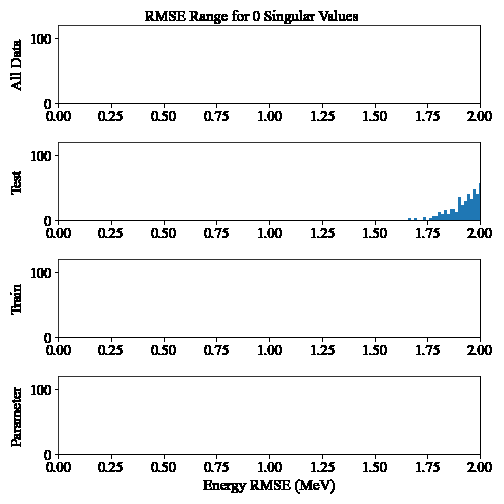

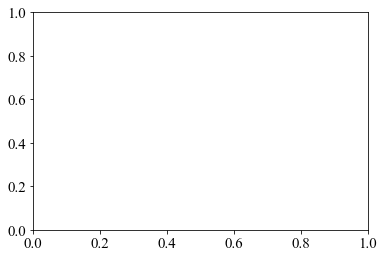

In [351]:
frame, axes = plt.subplots()
fs = 15
nBins = 75
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7,7))
def animate(i):
    axs[0].clear()
    axs[1].clear()
    axs[2].clear()
    axs[3].clear()
    axs[0].hist(eRMSRangeAll[:,i], bins=nBins)
    axs[1].hist(eRMSRangeTest[:,i], bins=nBins)
    axs[2].hist(eRMSRangeTrain[:,i], bins=nBins)
    axs[3].hist(pRMSRange[:,i], bins=nBins)
    axs[3].set_xlabel('Energy RMSE (MeV)', fontsize=fs)
    axs[0].set_ylabel('All Data', fontsize=fs)
    axs[1].set_ylabel('Test', fontsize=fs)
    axs[2].set_ylabel('Train', fontsize=fs)
    axs[3].set_ylabel('Parameter', fontsize=fs)

    axs[0].set_xlim(left=0, right=2.0)
    axs[1].set_xlim(left=0, right=2.0)
    axs[2].set_xlim(left=0, right=2.0)
    axs[3].set_xlim(left=0, right=2.0)
    axs[0].set_ylim(bottom=0, top=120)
    axs[1].set_ylim(bottom=0, top=120)
    axs[2].set_ylim(bottom=0, top=120)
    axs[3].set_ylim(bottom=0, top=120)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.95)
    plt.suptitle("RMSE Range for %i Singular Values" %i, fontsize=fs)
  
ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(x), interval=250)
f = r'batchAnimation80p.gif'
writergif = animation.PillowWriter(fps=10)
ani.save(f,writer=writergif)
plt.close()
Image(open('batchAnimation80p.gif','rb').read())